# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

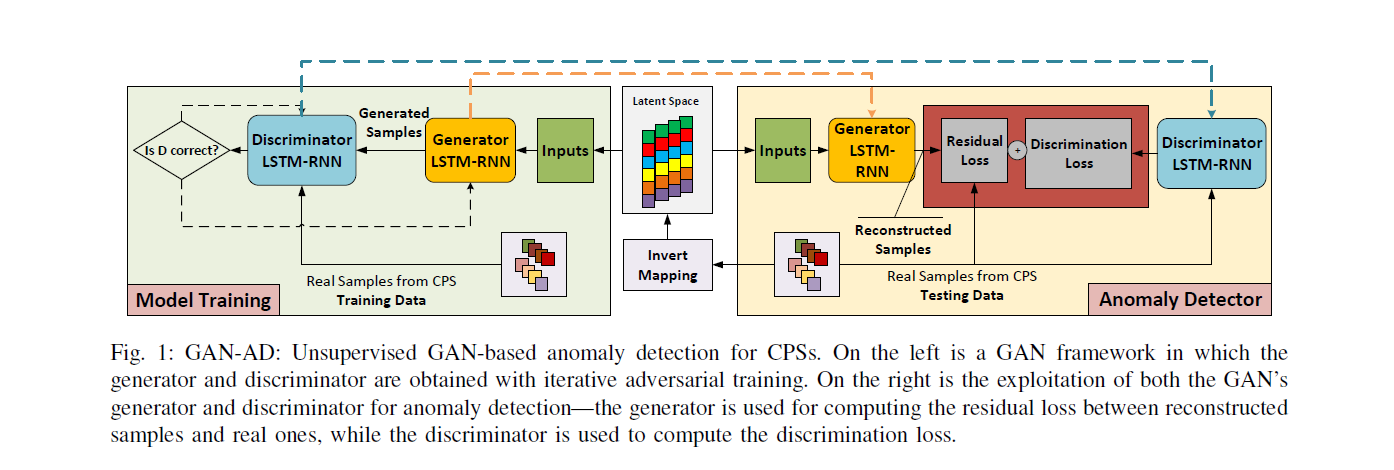

In [1]:
import os
import pandas as pd
import numpy as np
from time_series_anomaly_detection.detector import GAN_AD
import random
from datetime import date
import matplotlib.pyplot as plt

# Numenta Anomaly Benchmark (NAB)

Lavin, Alexander and Ahmad, Subutai. "Evaluating Real-time Anomaly Detection Algorithms – the Numenta Anomaly Benchmark", Fourteenth International Conference on Machine Learning and Applications, December 2015.
https://github.com/numenta/NAB

## Load and split data

In [2]:
# single univariate time series
df_original = pd.read_csv("../datasets/NAB/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv", index_col='timestamp', sep=',').reset_index(drop=True)

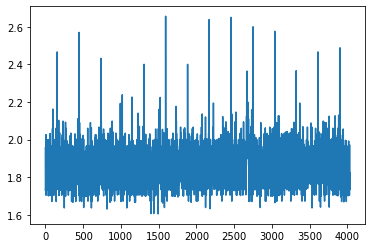

In [3]:
plt.plot(df_original)

In [4]:
ratio = 0.75
split = int(len(df_original)*ratio)
df_original, df_test = df_original.iloc[:split,:].reset_index(drop=True), df_original.iloc[split:,:].reset_index(drop=True)

In [5]:
ratio = 0.5
split = int(len(df_test)*ratio)
df_original_test, df_with_anomalies = df_test.iloc[:split,:].reset_index(drop=True), df_test.iloc[split:,:].reset_index(drop=True)

In [6]:
# insert dummy fake anomalies
random.seed(10)
anomaly_index = random.sample(range(0, df_with_anomalies.shape[0]), int(0.2*df_with_anomalies.shape[0]))
df_with_anomalies.iloc[anomaly_index, [0]] = df_with_anomalies.iloc[anomaly_index, [0]] * 0.75

In [7]:
df_anomalies_labels = df_with_anomalies.copy()
df_anomalies_labels['label'] = 0
df_anomalies_labels.iloc[anomaly_index, :] = 1
df_anomalies_labels = df_anomalies_labels.drop(columns=['value'])

## Model's parameters settings

In [8]:
# values selected based on experiments
window_size = 8
shift = 3
batch_size = 16
latent_dim = 1 
n_features = df_original.shape[1]

## Training

In [9]:
gan_ad = GAN_AD(window_size, shift, batch_size, latent_dim, n_features)
gan_ad.fit(df_original, 10000, save_checkpoints=True, enable_prints=True)
# gan_ad.save_model("gan_ad_" + str(date.today()) + "-cpu.h5")

KeyboardInterrupt: 

## Loading best weights


In [10]:
# gan_ad.load_weights("gan_ad_2021-05-01_epoch_9000.h5")
from tensorflow import keras
gan_ad._gan_ad = keras.models.load_model('gan_ad_2021-05-02-cpu.h5')
gan_ad.fit_scaler(df_original)

## Evaluation

### Anomaly free (training) data

In [11]:
# less than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original[0:0+window_size-5]))
anomaly_scores

0   NaN
1   NaN
2   NaN
dtype: float64

Anomaly free (training) data with NaNs - anomaly scores


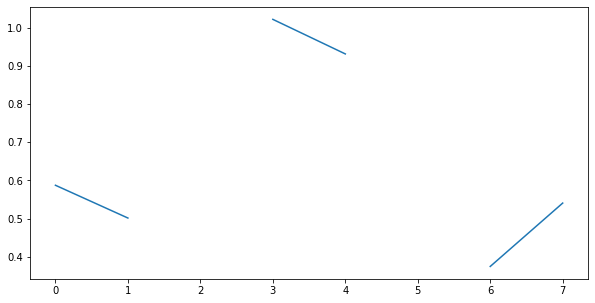

In [12]:
# one window with NaN values
window_with_nan = pd.DataFrame(df_original[0:0+window_size].copy())
window_with_nan.iloc[[2,5], [0]] = np.nan
# display(windows_with_nan)

anomaly_scores = gan_ad.predict_anomaly_scores(window_with_nan)
print('Anomaly free (training) data with NaNs - anomaly scores')
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

Anomaly free (training) data - anomaly scores


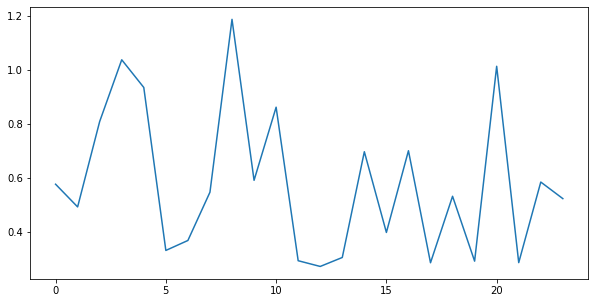

In [13]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original[0:0+(2*window_size)+8]))
print('Anomaly free (training) data - anomaly scores')
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

### Anomaly free (test) data

Anomaly free (test) data - anomaly scores


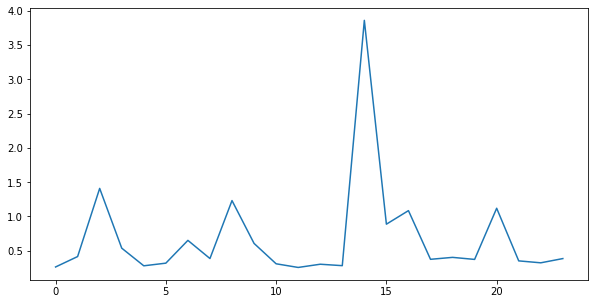

In [14]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original_test[0:0+window_size*3]))
print('Anomaly free (test) data - anomaly scores')
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

### Data with (inserted) anomalies

Original data with anomalies


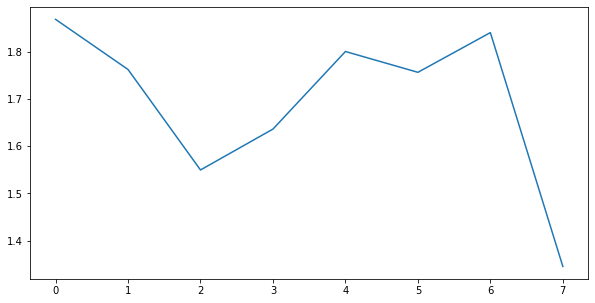

Scaled data with anomalies - true anomalies


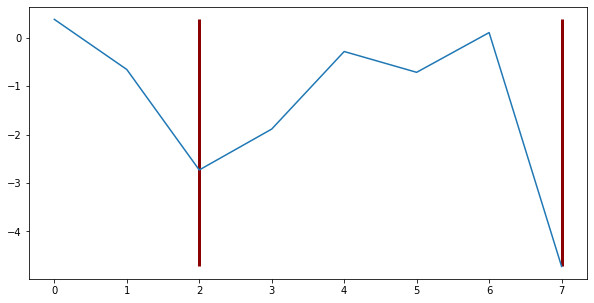

Scaled data with anomalies - predicted anomaly scores


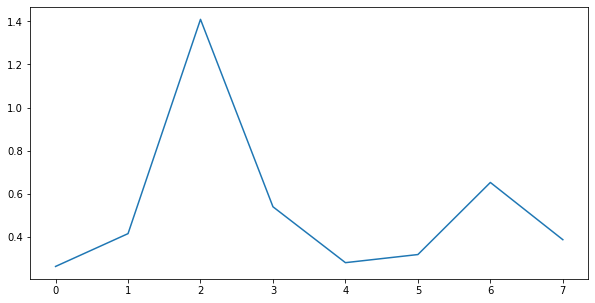

Scaled data with anomalies - predicted anomalies
anomaly_score
0    0.395859
1    0.548682
2    1.565144
3    1.208458
4    0.424350
5    0.451585
6    0.404699
7    2.580272
dtype: float64
cross_entropy
0   -0.926697
1   -0.600236
2    0.447978
3    0.189345
4   -0.857196
5   -0.794993
6   -0.904612
7    0.947895
dtype: float64


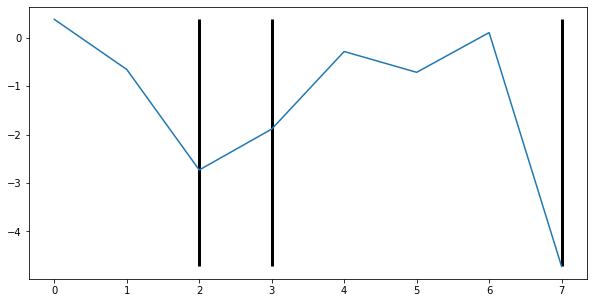

In [15]:
# one window
print('Original data with dummy anomalies')
data = pd.DataFrame(df_with_anomalies[0:0+window_size])
plt.figure(figsize=(10,5))
plt.plot(data)
plt.show()

print('Scaled data with anomalies - true anomalies')
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:0+window_size]))
plt.figure(figsize=(10,5))
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:0+window_size]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

print('Scaled data with anomalies - predicted anomaly scores')
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original_test[0:0+window_size]))
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

print('Scaled data with anomalies - predicted anomalies')
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:0+window_size]), threshold = 0)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(10,5))
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()

Original data with anomalies


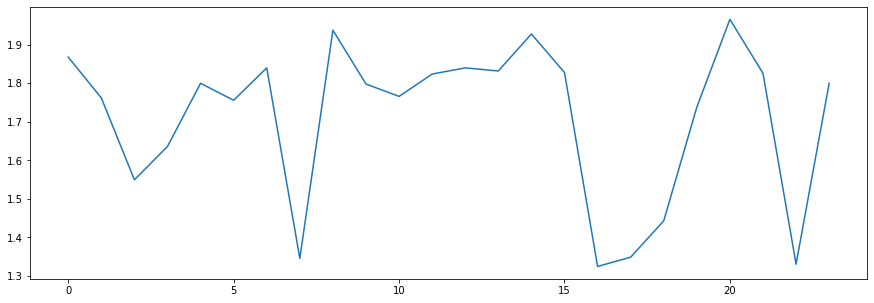

Scaled data with anomalies - true anomalies


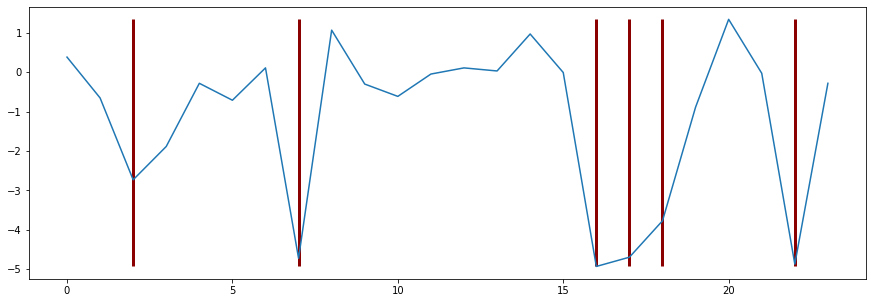

Scaled data with anomalies - predicted anomaly scores


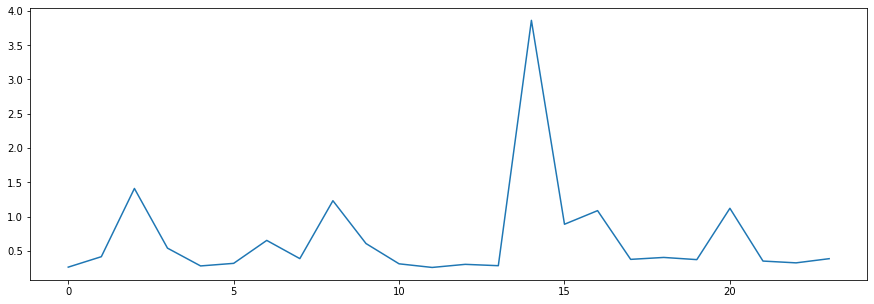

Scaled data with anomalies - predicted anomalies
anomaly_score
0     0.397038
1     0.547550
2     1.564588
3     1.209961
4     0.425115
5     0.449501
6     0.404745
7     2.580070
8     0.783862
9     0.398802
10    0.553387
11    0.277916
12    0.297372
13    0.259254
14    0.727553
15    0.256544
16    2.761055
17    2.565713
18    2.083848
19    0.713802
20    0.887984
21    0.398328
22    2.586534
23    0.358922
dtype: float64
cross_entropy
0    -0.923724
1    -0.602302
2     0.447623
3     0.190588
4    -0.855396
5    -0.799617
6    -0.904498
7     0.947817
8    -0.243522
9    -0.919290
10   -0.591698
11   -1.280436
12   -1.212771
13   -1.349945
14   -0.318068
15   -1.360455
16    1.015613
17    0.942236
18    0.734216
19   -0.337150
20   -0.118801
21   -0.920481
22    0.950319
23   -1.024649
dtype: float64


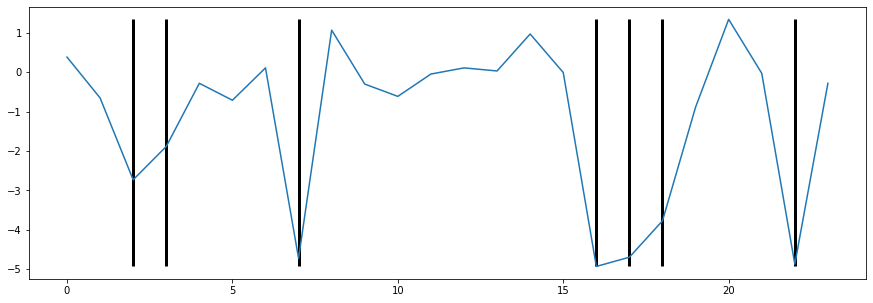

In [16]:
# more than one window
print('Original data with dummy anomalies')
data = pd.DataFrame(df_with_anomalies[0:0+window_size*3])
plt.figure(figsize=(15,5))
plt.plot(data)
plt.show()

print('Scaled data with anomalies - true anomalies')
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:0+window_size*3]))
plt.figure(figsize=(15,5))
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:0+window_size*3]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

print('Scaled data with anomalies - predicted anomaly scores')
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_original_test[0:0+window_size*3]))
plt.figure(figsize=(15,5))
plt.plot(anomaly_scores)
plt.show()


print('Scaled data with anomalies - predicted anomalies')
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:0+window_size*3]), threshold = 0)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(15,5))
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()